Задание выполнялось в Google colab. Для начала импортируем необходимые модули, подключимся к google диску, и откроем csvшники.


In [1]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 8.2MB 6.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
import re
import pymorphy2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
positive_df = pd.read_csv('/content/drive/My Drive/Интерсвязь/Тестовое задание/positive.csv', sep=';', header=None)
negative_df = pd.read_csv('/content/drive/My Drive/Интерсвязь/Тестовое задание/negative.csv', sep=';', header=None)

In [5]:
positive_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [6]:
negative_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


Добавим названия признаков

In [7]:
new_columns = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtv', 'fav', 'text_counts', 'foll', 'friends', 'list_count']

In [8]:
positive_df.columns = new_columns
negative_df.columns = new_columns

In [9]:
positive_df.head()

,id,date,name,text,type,rep,rtv,fav,text_counts,foll,friends,list_count
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [10]:
negative_df.head()

,id,date,name,text,type,rep,rtv,fav,text_counts,foll,friends,list_count
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


Проверим наличие пропусков в данных 

In [11]:
positive_df.isnull().sum(), negative_df.isnull().sum()

(id             0
 date           0
 name           0
 text           0
 type           0
 rep            0
 rtv            0
 fav            0
 text_counts    0
 foll           0
 friends        0
 list_count     0
 dtype: int64, id             0
 date           0
 name           0
 text           0
 type           0
 rep            0
 rtv            0
 fav            0
 text_counts    0
 foll           0
 friends        0
 list_count     0
 dtype: int64)

Объединим датасеты

In [12]:
df = pd.concat([positive_df, negative_df])
df.date = pd.to_datetime(df.date, unit='s')
df = df.sort_values(by=['date'])

Обработаем тексты твитов

In [13]:
morph = pymorphy2.MorphAnalyzer()

In [14]:
tqdm.pandas()

Лемматизируем текст

In [15]:
df['text_lemm'] = df['text'].progress_apply(lambda row: [morph.parse(word)[0].normal_form for word in re.findall(r'\w+', row)])

100%|██████████| 226834/226834 [11:17<00:00, 334.64it/s]


In [16]:
df['text_lemm']

0         [first_timee, хоть, я, и, школотый, но, поверь...
1         [да, всё, таки, он, немного, похожий, на, он, ...
2         [rt, katiacheh, ну, ты, идиотка, я, испугаться...
3         [rt, digger2912, кто, то, в, угол, сидеть, и, ...
4         [irina_dyshkant, вот, что, значит, страшилка, ...
                                ...                        
111918    [но, не, каждый, хотеть, что, то, исправлять, ...
111919    [скучать, так, только, taaannyaaa, вправлять, ...
111920    [вот, и, в, школа, в, говно, это, идти, уже, н...
111921    [rt, _them__, lisaberoud, тауриэль, не, грусть...
111922    [такси, везти, я, на, работа, раздумывать, при...
Name: text_lemm, Length: 226834, dtype: object

In [17]:
df['text_lemm'] = df['text_lemm'].apply(lambda x: ' '.join(x))

In [18]:
df.head()

,id,date,name,text,type,rep,rtv,fav,text_counts,foll,friends,list_count,text_lemm
0,408906692374446080,2013-12-06 10:32:07,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,first_timee хоть я и школотый но поверь у мы т...
1,408906692693221377,2013-12-06 10:32:07,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,да всё таки он немного похожий на он но мой ма...
2,408906695083954177,2013-12-06 10:32:07,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,rt katiacheh ну ты идиотка я испугаться за ты
3,408906695356973056,2013-12-06 10:32:07,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,rt digger2912 кто то в угол сидеть и погибать ...
4,408906761416867842,2013-12-06 10:32:23,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,irina_dyshkant вот что значит страшилка d но б...


TF-IDF + logreg

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(2, 5),  analyzer='word')

In [21]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 5), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [22]:
X = vectorizer.fit_transform(df['text_lemm'])
y = df.type

In [23]:
X.shape, y.shape

((226834, 5791728), (226834,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [25]:
X_train.shape, y_train.shape

((151978, 5791728), (151978,))

In [26]:
X_test.shape, y_test.shape

((74856, 5791728), (74856,))

В качестве модели используем логистическую регрессию (логрег)

In [27]:
logreg = LogisticRegression()

In [28]:
params = {'C': np.logspace(-5, 5, 11)}

Найдем оптимальные гиперпараметры логрега

In [29]:
grid_logreg = GridSearchCV(logreg, params, n_jobs=-1, scoring='roc_auc' ,cv=5)

In [30]:
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [38]:
grid_logreg.best_estimator_, \
grid_logreg.best_params_, \
grid_logreg.best_score_

(LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False), {'C': 100.0}, 0.787263133815074)

In [32]:
result = grid_logreg.predict(X_test)

In [33]:
result.shape, y_test.shape

((74856,), (74856,))

In [34]:
from sklearn.metrics import  roc_auc_score, roc_curve

AUC: 0.712


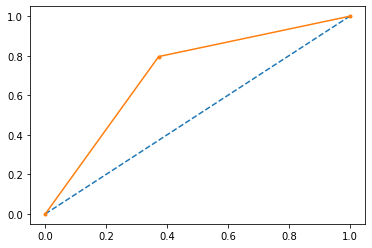

In [36]:
auc = roc_auc_score(y_test, result)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=result)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')